In [1]:
import json
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import datetime

from scipy.spatial import distance
from scipy.stats import randint
from scipy.signal import savgol_filter

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_error

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.preprocessing import StandardScaler


import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation
import joblib

import seaborn as sns

In [2]:
with open(f"C:/Users/ltuesta/Desktop/Files/Dev/local_python/data/data_biomass_simu.json", 'r') as f:
    parcelles = json.load(f)
print(len(parcelles))

228


In [3]:
def interpolate_linear(liste):
    # Boucle pour l'interpolation linéaire
    for i in range(len(liste)):
        if liste[i] is None:
            # Trouver les indices des valeurs non nulles les plus proches
            j = i - 1
            while liste[j] is None:
                j -= 1
            k = i + 1
            while k < len(liste) and liste[k] is None:
                k += 1
            # Calculer la valeur intermédiaire
            if j < 0:
                valeur_intermediaire = liste[k]
            elif k >= len(liste):
                valeur_intermediaire = liste[-1]
            else:
                valeur_intermediaire = liste[j] + (liste[k] - liste[j]) * (i - j) / (k - j)
            # Remplacer la valeur None par la valeur intermédiaire
            liste[i] = valeur_intermediaire
    
    none_indices = [i for i, liste in enumerate(liste) if liste is None]
    
    try : 
        last = none_indices[0]
        for i in range(last, len(liste)):
            liste[i] = liste[last-1]
    except IndexError:
        pass
    return liste

In [4]:
def correction(X):
    interpolated = interpolate_linear(X)
    polynomial_regression = savgol_filter(interpolated, window_length=11, polyorder=5, mode="nearest")
    max_poly = [max(interpolated[i], polynomial_regression[i]) for i in range(len(interpolated))]

    return max_poly

In [5]:
def month(date, band):
    monthly = []
    
    for i in range(1, 13):
        datetimes = [datetime.datetime.fromtimestamp(t/1000) for t in date]
        is_first_half = [d.month == i and d.day <= 15 for d in datetimes] # bool list of first 15 days of month
        val = np.array([x for x, m in zip(band, is_first_half) if m and x is not None])
        
        if len(val) > 0 :
            monthly.append(val.sum() / len(val))
        else :
            monthly.append(None)

        
        is_second_half = [d.month == i and d.day > 15 for d in datetimes] # bool list of last 15 days of month
        val = np.array([x for x, m in zip(band, is_second_half) if m and x is not None])
        
        if len(val) > 0 :
            monthly.append(val.sum() / len(val))
        else :
            monthly.append(None)
        
    return correction(monthly)

In [6]:
def normalize_parcelles(parcelles):
    X = []
    y = []
    for i in parcelles:
        try :
                
            parcel = parcelles[str(i)]['data']
            arrays = np.array([value for keys, value in parcel.items()])
            
            indices = np.where(arrays[1] == None)
            date = np.delete(arrays[0], indices)
    
            montly = []
            for j in range(1, 15):
                band = np.delete(arrays[j], indices)
                montly.append(month(date, band))

            y.append(np.array(montly).T[:,0])
            X.append(np.array(montly).T[:,1:])
        except Exception:
            print('error')
            pass

    return X, y

In [7]:
def create_list(i):
    return np.array([j for j in range(i) for _ in range(24)])

In [8]:
X, y = normalize_parcelles(parcelles)

error
error
error


In [9]:
families = create_list(len(parcelles)-3)
X = np.reshape(X, (-1, 13))
X = np.delete(X, 10, axis=1)
y =  np.reshape(y, (-1)) * 7

## Brazil 

In [10]:
df = pd.read_csv("../data/doBrazil/Complete_DataSet.csv")
df.drop_duplicates(subset = "Lat", keep = 'first', inplace=True)
Xb = np.array(df[['B1', 'B2', 'B3', 'B4', 'B5',
       'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']])
yb = np.array(df[['Biomass']])

## Analyses

array([[<Axes: title={'center': '0'}>]], dtype=object)

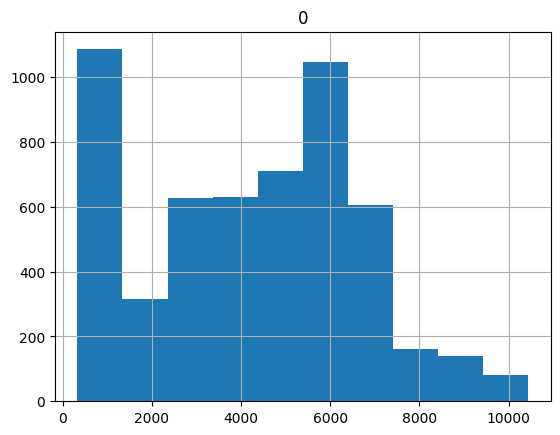

In [16]:
pd.DataFrame(y).hist()

array([[<Axes: title={'center': '0'}>]], dtype=object)

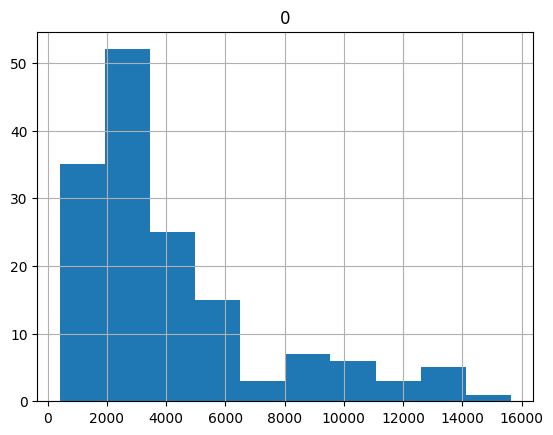

In [17]:
pd.DataFrame(yb).hist()

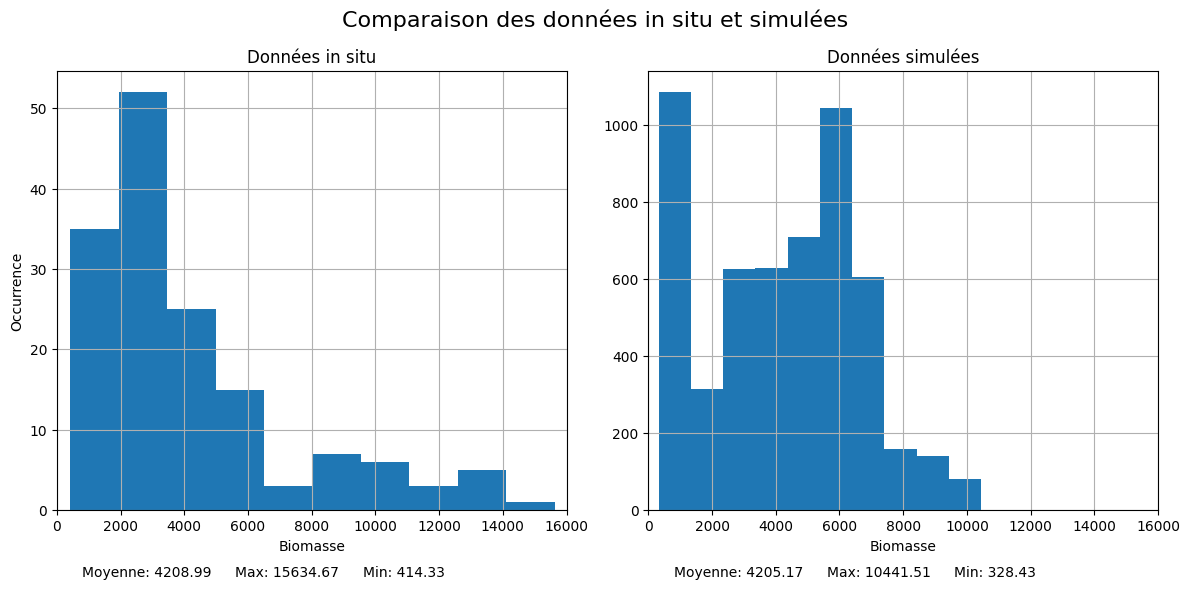

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Tracer le premier histogramme dans le premier sous-graphique
pd.DataFrame(yb).hist(ax=axes[0])
axes[0].set_title('Données in situ')
axes[0].set_xlabel('Biomasse')
axes[0].set_ylabel('Occurrence')
axes[0].set_xlim(0, 16000)

# Calculer les statistiques pour yb
mean_yb = pd.DataFrame(yb).mean()[0]
max_yb = pd.DataFrame(yb).max()[0]
min_yb = pd.DataFrame(yb).min()[0]

# Ajouter les informations sous le premier histogramme
axes[0].text(0.05, -0.15, f'Moyenne: {mean_yb:.2f}', transform=axes[0].transAxes)
axes[0].text(0.35, -0.15, f'Max: {max_yb:.2f}', transform=axes[0].transAxes)
axes[0].text(0.60, -0.15, f'Min: {min_yb:.2f}', transform=axes[0].transAxes)

# Tracer le deuxième histogramme dans le deuxième sous-graphique
pd.DataFrame(y).hist(ax=axes[1])
axes[1].set_title('Données simulées')
axes[1].set_xlabel('Biomasse')
axes[1].set_xlim(0, 16000)
# Calculer les statistiques pour y
mean_y = pd.DataFrame(y).mean()[0]
max_y = pd.DataFrame(y).max()[0]
min_y = pd.DataFrame(y).min()[0]

# Ajouter les informations sous le deuxième histogramme
axes[1].text(0.05, -0.15, f'Moyenne: {mean_y:.2f}', transform=axes[1].transAxes)
axes[1].text(0.35, -0.15, f'Max: {max_y:.2f}', transform=axes[1].transAxes)
axes[1].text(0.60, -0.15, f'Min: {min_y:.2f}', transform=axes[1].transAxes)

# Ajuster l'espacement entre les sous-graphiques
fig.suptitle('Comparaison des données in situ et simulées', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1])


# Afficher la figure
plt.show()

## Modele

In [71]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
Xbrazil = scaler.transform(Xbrazil)

In [80]:
Xb = scaler.transform(Xb)

In [264]:
scaler_y = StandardScaler().fit(yb)
y = scaler_y.transform(np.reshape(y,( -1,1)))
yb = scaler_y.transform(yb)

In [30]:
X_train, X_test, y_train, y_test, f_train, f_test = train_test_split(X, y, families, test_size=0.2, random_state=42)

In [31]:
def display_result(y_pred, y_test):
    plt.scatter(y_pred, y_test)
    plt.plot([0, 16000], [0, 16000], c='red')
    plt.show()

    print(f'R2_score : {r2_score(y_test.flatten(), y_pred)}')
    print(f'root_mean_squared_error : {root_mean_squared_error(y_test.flatten(), y_pred)}')
    print(f'root_mean_squared_error % : {root_mean_squared_error(y_test.flatten(), y_pred)/y_test.mean()}')
    print(f'mean_absolute_error : {mean_absolute_error(y_test.flatten(), y_pred)}')
    print(f'mean_absolute_error % : {mean_absolute_error(y_test.flatten(), y_pred)/y_test.mean()}')

## XGBoost

In [190]:
params = {'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 310}

In [195]:
xgb = GradientBoostingRegressor(**params)
xgb.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=10, max_features=5, min_samples_leaf=2,
                          min_samples_split=4, n_estimators=310)

In [196]:
y_pred = xgb.predict(Xb)

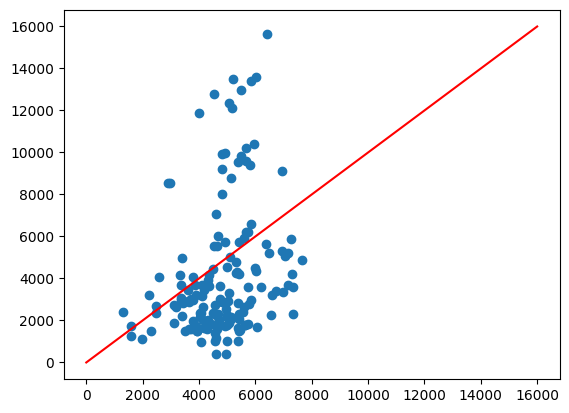

R2_score : 0.03122792995205692
root_mean_squared_error : 3150.660231269448
root_mean_squared_error % : 0.7485545204841814
mean_absolute_error : 2495.9306423041385
mean_absolute_error % : 0.5929995708737426


In [201]:
display_result(y_pred, yb)

## random Search CV

In [137]:
rs_space={'max_depth':list(np.arange(10, 100, step=10)) + [None],
          'n_estimators':np.arange(10, 500, step=50),
          'max_features':randint(1,7),
          'min_samples_leaf':randint(1,4),
          'min_samples_split':np.arange(2, 10, step=2),
          }

xg = GradientBoostingRegressor()

xg_random = RandomizedSearchCV(xg, rs_space, n_iter=60, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)

In [138]:
model_random = xg_random.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [139]:
model_random.cv_results_

{'mean_fit_time': array([ 56.5530827 ,  10.12533374,  38.61198554,  36.09385576,
         32.14611473,   9.03266292,   1.168047  ,  17.862674  ,
          1.09453311,  32.80574012,  24.44405909,   7.0205586 ,
          9.45049105, 168.52107272,   3.50818534,   7.43606339,
         20.24094725,   1.39755368,  21.23631744,  10.87268071,
         36.04019465,  17.06372685,  41.35239124,  51.80667911,
          0.37825289,  31.51947298,   0.95647259,   5.37351704,
        117.03257971,  12.02368717,  40.721696  ,  88.50930438,
          0.25102673,  18.43910642,  39.80629082,  49.23288178,
         26.15423193,   3.64640384,  40.03565321,  44.92444301,
         16.39271765,  60.15880051,  44.53109021,   0.27329373,
         19.67432942,   6.04430466,   0.71324229,  22.46548858,
          0.43429856,   9.86542115,  24.70533113,   0.52551947,
          1.17979469,  40.28715334,   0.55705805,   0.89437685,
          3.07306676,  27.40500612,   4.84994907,  29.11926489]),
 'std_fit_time': arra

In [140]:
print('Best random search hyperparameters are: '+str(model_random.best_params_))
print('Best random search score is: '+ str(model_random.best_score_))

Best random search hyperparameters are: {'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 310}
Best random search score is: -53409.79765361976


## Best result off Random Search

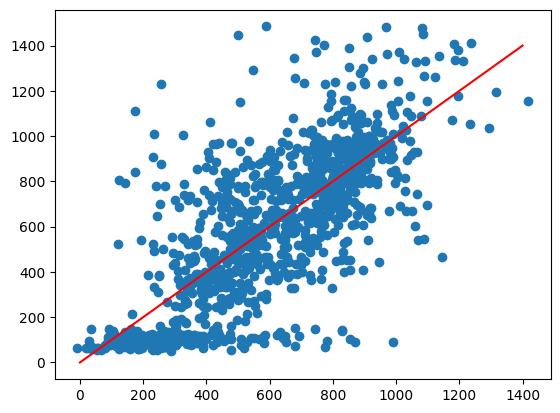

R2_score : 0.5567505087236884
root_mean_squared_error : 228.36974825820104
root_mean_squared_error % : 0.38269938054408004
mean_absolute_error : 164.98096503281073
mean_absolute_error % : 0.27647319139764315


In [141]:
params = model_random.best_params_
xgb = GradientBoostingRegressor(**params)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
display_result(y_pred, y_test)

In [136]:
print(f'0.5556111293954709 : {params}')

0.5556111293954709 : {'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 310}


## Random Forest

In [74]:
rfc = RandomForestRegressor()
rfc.fit(X, y)

RandomForestRegressor()

In [83]:
y_pred = rfc.predict(Xbrazil)

In [85]:
def display_result(y_pred, y_test):
    # Tracer les points de prédiction
    plt.scatter(y_test, y_pred)

    # Tracer la ligne de référence (y = x)
    plt.plot([0, 16000], [0, 16000], c='red', label='y = x')

    # Calculer les métriques de performance
    r2 = r2_score(y_test.flatten(), y_pred)
    mse = mean_squared_error(y_test.flatten(), y_pred)
    mse_percent = mse / y_test.mean()
    rmse = root_mean_squared_error(y_test.flatten(), y_pred)
    rmse_percent = rmse / y_test.mean()
    mae = mean_absolute_error(y_test.flatten(), y_pred)
    mae_percent = mae / y_test.mean()

    # Ajouter des annotations pour les métriques de performance
    plt.figtext(0.95, 0.6, f'R2_score: {r2:.3f}', ha='left')
    plt.figtext(0.95, 0.55, f'RMSE: {rmse:.3f}', ha='left')
    plt.figtext(0.95, 0.50, f'RMSE %: {rmse_percent:.3%}', ha='left')
    plt.figtext(0.95, 0.45, f'MAE: {mae:.3f}', ha='left')
    plt.figtext(0.95, 0.4, f'MAE %: {mae_percent:.3%}', ha='left')

    # Ajouter des labels et une légende
    plt.ylabel('Valeurs prédites')
    plt.xlabel('Valeurs réelles')
    plt.xlim(0,8000)
    plt.ylim(0,8000)
    #plt.legend()
    plt.title("Résultats du modèle d'estimation de biomasse")

    # Afficher le graphique
    plt.savefig('biomasse_estimation.png', bbox_inches='tight')
    plt.show()

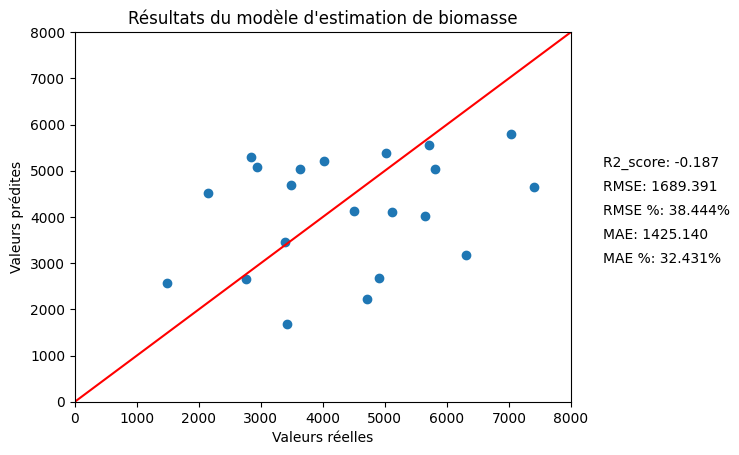

In [86]:
display_result(y_pred, ybrazil)

In [280]:
np.shape(X_test)

(1080, 12)

In [283]:
X_new = np.append(Xb, X_test, axis=0)

In [284]:
y_new = np.append(yb, y_test)

In [285]:
np.shape(y_new)

(1232,)

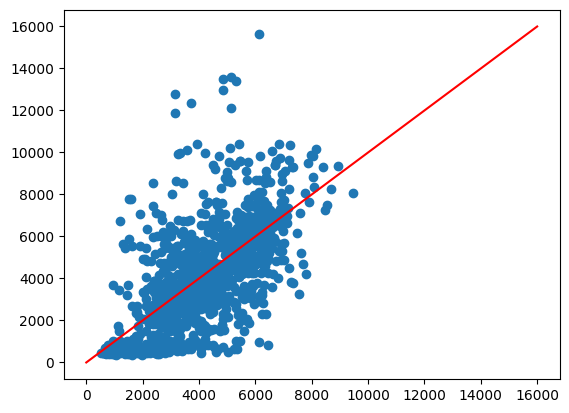

R2_score : 0.44646556781472124
root_mean_squared_error : 1870.1384331777408
root_mean_squared_error % : 0.44728721998940185
mean_absolute_error : 1322.8598259212595
mean_absolute_error % : 0.31639277792209747


In [289]:
y_pred = np.reshape(rfc.predict(X_new), (-1, 1))
display_result(scaler_y.inverse_transform(y_pred), scaler_y.inverse_transform(np.reshape(y_new,(-1,1))))

In [251]:
scaler_y = StandardScaler().fit(yb)

array([[<Axes: title={'center': '0'}>]], dtype=object)

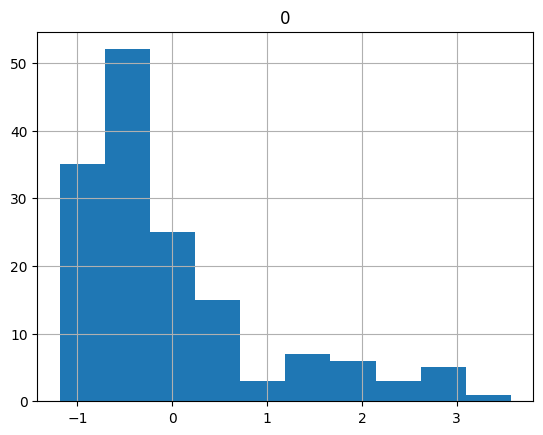

In [254]:
pd.DataFrame(scaler_y.transform(yb)).hist()

array([[<Axes: title={'center': '0'}>]], dtype=object)

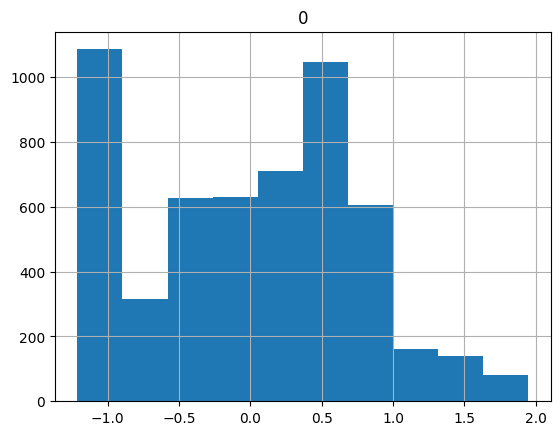

In [258]:
pd.DataFrame(scaler_y.transform(np.reshape(y,(-1,1)))).hist()

In [259]:
np.mean(scaler_y.transform(np.reshape(y,(-1,1))))

-0.0011935149446488944

In [260]:
np.mean(scaler_y.transform(yb))

-2.1035804677108228e-16

## Mixte data simu / obs

#### Brazil 

In [372]:
df = pd.read_csv("../data/doBrazil/Complete_DataSet.csv")
df.drop_duplicates(subset = "Lat", keep = 'first', inplace=True)
Xb = np.array(df[['B1', 'B2', 'B3', 'B4', 'B5',
       'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']])
yb = np.array(df[['Biomass']])

#### dynagramme 

In [346]:
X, y = normalize_parcelles(parcelles)
X = np.reshape(X, (-1, 13))
X = np.delete(X, 10, axis=1)
y = np.reshape(y, (-1, 1)) * 7

error
error
error


In [340]:
scaler = StandardScaler().fit(X)

In [341]:
X = np.array(scaler.transform(X))
Xb = np.array(scaler.transform(Xb))

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>],
       [<Axes: title={'center': '3'}>, <Axes: title={'center': '4'}>,
        <Axes: title={'center': '5'}>],
       [<Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>,
        <Axes: title={'center': '8'}>],
       [<Axes: title={'center': '9'}>, <Axes: title={'center': '10'}>,
        <Axes: title={'center': '11'}>]], dtype=object)

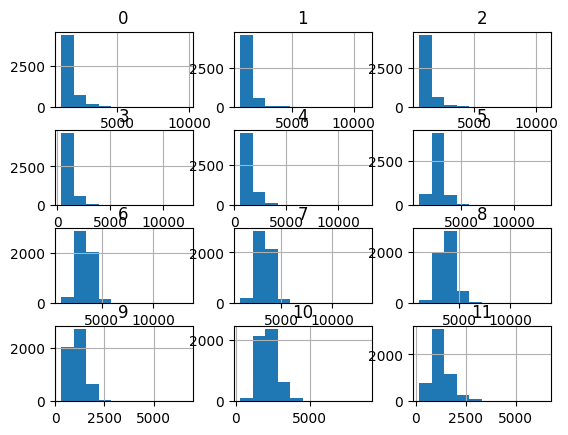

In [349]:
pd.DataFrame(X).hist()

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>],
       [<Axes: title={'center': '3'}>, <Axes: title={'center': '4'}>,
        <Axes: title={'center': '5'}>],
       [<Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>,
        <Axes: title={'center': '8'}>],
       [<Axes: title={'center': '9'}>, <Axes: title={'center': '10'}>,
        <Axes: title={'center': '11'}>]], dtype=object)

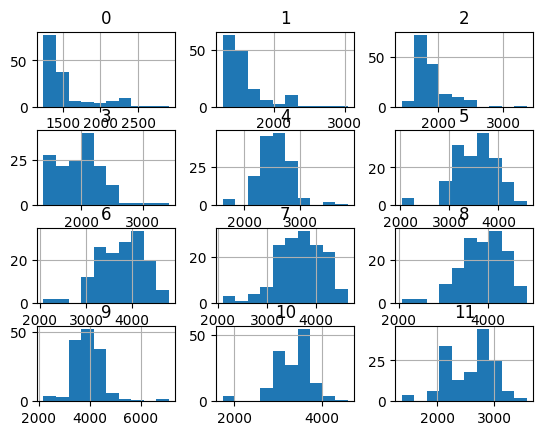

In [350]:
pd.DataFrame(Xb).hist()

In [302]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [311]:
X_new_train = np.append(X_train, Xb[:50,:],axis=0)

In [305]:
np.shape(Xb[:50,:])

(50, 12)

In [306]:
np.shape(X_test)

(1080, 12)

In [313]:
np.shape(X_new_train)

(4370, 12)

#### test

In [332]:
X

array([[4577.09800427, 4543.51461829, 4159.57149974, ...,  449.08553873,
        3522.523463  , 2217.55413433],
       [3315.18699403, 3040.5013577 , 2734.13131072, ...,  493.52826469,
        2779.70030809, 1458.29795672],
       [2714.81340844, 2361.00158506, 2139.08088111, ...,  601.74740939,
        2652.09034375, 1275.63733847],
       ...,
       [2908.88178332, 2412.29974066, 1845.30108848, ...,  267.19215418,
        1028.82650393,  380.70792569],
       [3215.39530812, 2659.46935203, 2030.80236165, ...,  332.91434435,
         980.72647498,  382.02913238],
       [3287.47854946, 2748.04560072, 2061.65542504, ...,  405.27297543,
         785.92533421,  336.76190344]])

C:\Users\ltuesta\AppData\Local\miniconda3\envs\testgdal\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


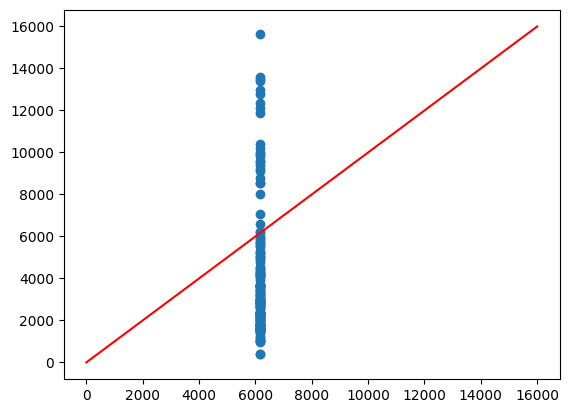

R2_score : -0.37773510534550425
root_mean_squared_error : 3757.2805878976515
root_mean_squared_error % : 0.8926793631647928
mean_absolute_error : 3397.1444895683853
mean_absolute_error % : 0.8071158670701062


In [320]:
rfc = RandomForestRegressor()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(Xb)
display_result(y_pred, yb)

In [ ]:
rfc = RandomForestRegressor()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(Xb)
display_result(y_pred, yb)

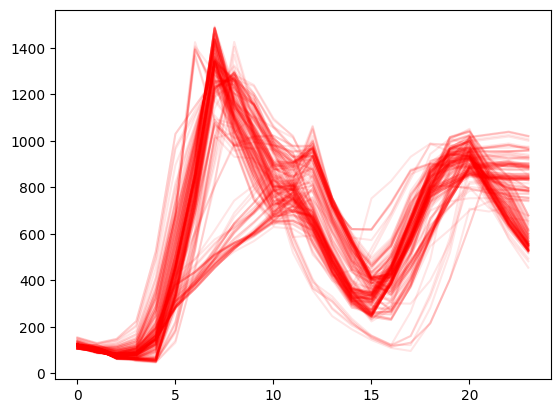

In [371]:
for yy in y:
    plt.plot(yy, alpha=0.1, c='red')
plt.show()

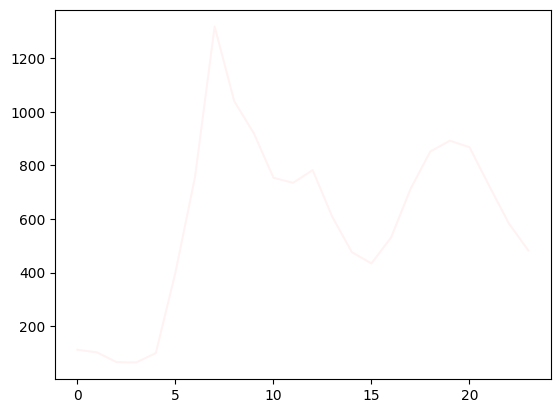

In [369]:
plt.plot(y[1], alpha=0.05, c='red')
plt.show()

In [16]:
df = pd.read_csv("../data/doBrazil/Complete_DataSet.csv")
df.drop_duplicates(subset = "Lat", keep = 'first', inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%M-%d')

In [63]:
tab = []
for idx, df__ in df.groupby("Date"):
    tab.append(df__[["Biomass",'B1', 'B2', 'B3', 'B4', 'B5','B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']].mean())

brazil = np.array(tab)

In [64]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%M-%d')

In [66]:
brazil

array([[4505.28571414, 1328.85714286, 1386.28571429, 1777.28571429,
        1793.14285714, 2514.        , 3562.42857143, 3781.57142857,
        3772.28571429, 3931.42857143, 3807.71428571, 3167.14285714,
        2377.28571429],
       [2757.76923069, 1414.23076923, 1563.23076923, 1848.30769231,
        2286.92307692, 2701.30769231, 3175.38461538, 3356.30769231,
        3393.        , 3520.07692308, 3460.38461538, 3668.69230769,
        3016.61538462],
       [4025.66666678, 1903.66666667, 1913.88888889, 2253.22222222,
        2238.88888889, 2980.88888889, 4187.44444444, 4472.44444444,
        4275.88888889, 4549.66666667, 4449.44444444, 3894.44444444,
        2999.33333333],
       [5718.2333333 , 1297.9       , 1344.8       , 1725.5       ,
        1574.3       , 2317.        , 3834.1       , 4135.        ,
        4041.2       , 4233.4       , 4166.        , 2965.5       ,
        2104.9       ],
       [5013.966667  , 1333.2       , 1388.3       , 1711.6       ,
        1513.2      

In [69]:
ybrazil = brazil[:, 0]
Xbrazil = brazil[:, 1:]

In [68]:
ybrazil

array([4505.28571414, 2757.76923069, 4025.66666678, 5718.2333333 ,
       5013.966667  , 4711.18750038, 1483.54166661, 2839.91666675,
       3383.25925922, 3634.0555555 , 2144.86666654, 7399.0666666 ,
       7031.944445  , 4899.61111183, 5642.11111117, 6313.        ,
       2939.94444433, 5806.05555567, 3490.33333325, 3426.20833287,
       5116.5       ])

In [70]:
Xbrazil

array([[1328.85714286, 1386.28571429, 1777.28571429, 1793.14285714,
        2514.        , 3562.42857143, 3781.57142857, 3772.28571429,
        3931.42857143, 3807.71428571, 3167.14285714, 2377.28571429],
       [1414.23076923, 1563.23076923, 1848.30769231, 2286.92307692,
        2701.30769231, 3175.38461538, 3356.30769231, 3393.        ,
        3520.07692308, 3460.38461538, 3668.69230769, 3016.61538462],
       [1903.66666667, 1913.88888889, 2253.22222222, 2238.88888889,
        2980.88888889, 4187.44444444, 4472.44444444, 4275.88888889,
        4549.66666667, 4449.44444444, 3894.44444444, 2999.33333333],
       [1297.9       , 1344.8       , 1725.5       , 1574.3       ,
        2317.        , 3834.1       , 4135.        , 4041.2       ,
        4233.4       , 4166.        , 2965.5       , 2104.9       ],
       [1333.2       , 1388.3       , 1711.6       , 1513.2       ,
        2194.2       , 3752.7       , 4122.4       , 3995.4       ,
        4186.7       , 4074.2       , 2958.9